In [1]:
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import contextily as ctx

import pygmo as pg

## Load Data

Processed in population_data.ipynb notebook.

In [2]:
tyne_oa = gpd.read_file("data/tyne_oa")
tyne_oa.head()

,oa11cd,lad11cd,X,Y,Population,geometry
0,E00042042,E08000021,421259.393,564639.754,310,"POLYGON ((421301.772 564928.429, 421301.755 56..."
1,E00042043,E08000021,420448.616,564819.213,304,"POLYGON ((420572.364 564892.821, 420572.312 56..."
2,E00042044,E08000021,420509.207,564622.209,246,"POLYGON ((420492.559 564780.806, 420492.590 56..."
3,E00042045,E08000021,421551.722,564088.460,201,"POLYGON ((421543.715 563955.116, 421542.251 56..."
4,E00042046,E08000021,422116.597,563648.529,424,"POLYGON ((422292.813 563736.716, 422265.374 56..."


## Calculate Distances Between Output Areas

In [3]:
centroids = np.array([tyne_oa["X"], tyne_oa["Y"]]).T
centroids.shape

(952, 2)

In [4]:
dist_sq = np.sum((centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                 axis = -1)

distances = np.sqrt(dist_sq)

Max distance of 16923.71770783074 m is between E00042743 and E00139704


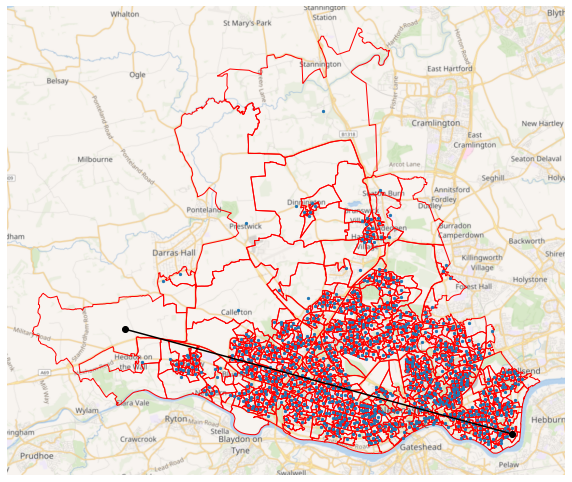

In [5]:
max_idx = np.where(distances == distances.max())[0]
print("Max distance of",
      distances.max(),
      "m is between",
      tyne_oa.iloc[max_idx[0]]["oa11cd"],
      "and", tyne_oa.iloc[max_idx[1]]["oa11cd"])

ax = tyne_oa.plot(figsize=(10,10), facecolor='none', edgecolor='red')
ctx.add_basemap(ax,
                url="https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

x = tyne_oa["X"]
y = tyne_oa["Y"]
ax.scatter(x, y, s=5)

x = tyne_oa.iloc[max_idx]["X"]
y = tyne_oa.iloc[max_idx]["Y"]
ax.plot(x, y, 'k-o')

ax.set_axis_off()

## Calculate "satisfaction"

Satisfaction at any output area due to a sensor placed in any other output area.

In [6]:
def distance_to_satisfaction(distance, theta=1):
    return np.exp(- distance / theta)

distance_to_satisfaction = np.vectorize(distance_to_satisfaction)

Text(0, 0.5, 'satisfaction')

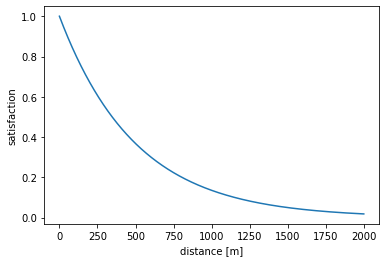

In [7]:
theta = 500

d = np.arange(0, 2000)

plt.plot(d, distance_to_satisfaction(d, theta=theta))
plt.xlabel("distance [m]")
plt.ylabel("satisfaction")

In [8]:
satisfaction = distance_to_satisfaction(distances, theta=theta)

Text(0.5, 1, 'Satisfaction due to sensor at E00042042')

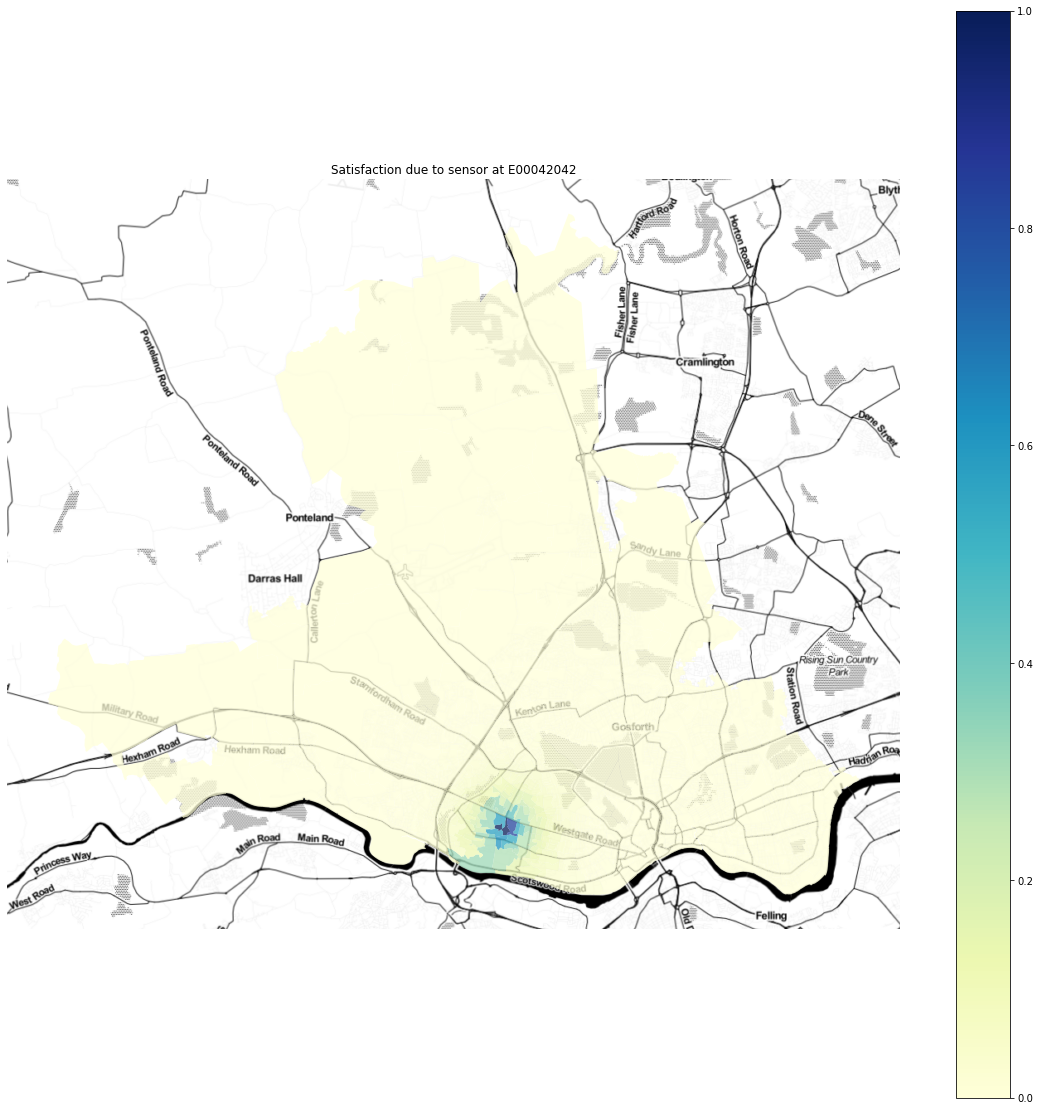

In [9]:
# satisfaction due to sensor at this output area index
sensor_idx = 0

tyne_oa["satisfaction"] = satisfaction[sensor_idx]

ax = tyne_oa.plot(column="satisfaction",
                  figsize=(20,20),alpha=0.75,
                  cmap="YlGnBu", legend=True)

ctx.add_basemap(ax,
                url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

ax.set_axis_off()
plt.title("Satisfaction due to sensor at " +
          tyne_oa.iloc[sensor_idx]["oa11cd"])

In [10]:
sensors = np.zeros((len(tyne_oa)))

# add sensors at random location
n_sensors = 10
sensor_idx = np.random.randint(0, len(tyne_oa), size=n_sensors)
sensors[sensor_idx] = 1

# only keep satisfactions due to output areas where a sensor is present
mask_sat = np.multiply(satisfaction, sensors[np.newaxis, :])

# satisfaction at each output area = satisfaction due to nearest sensor
max_mask_sat = np.max(mask_sat, axis=1)

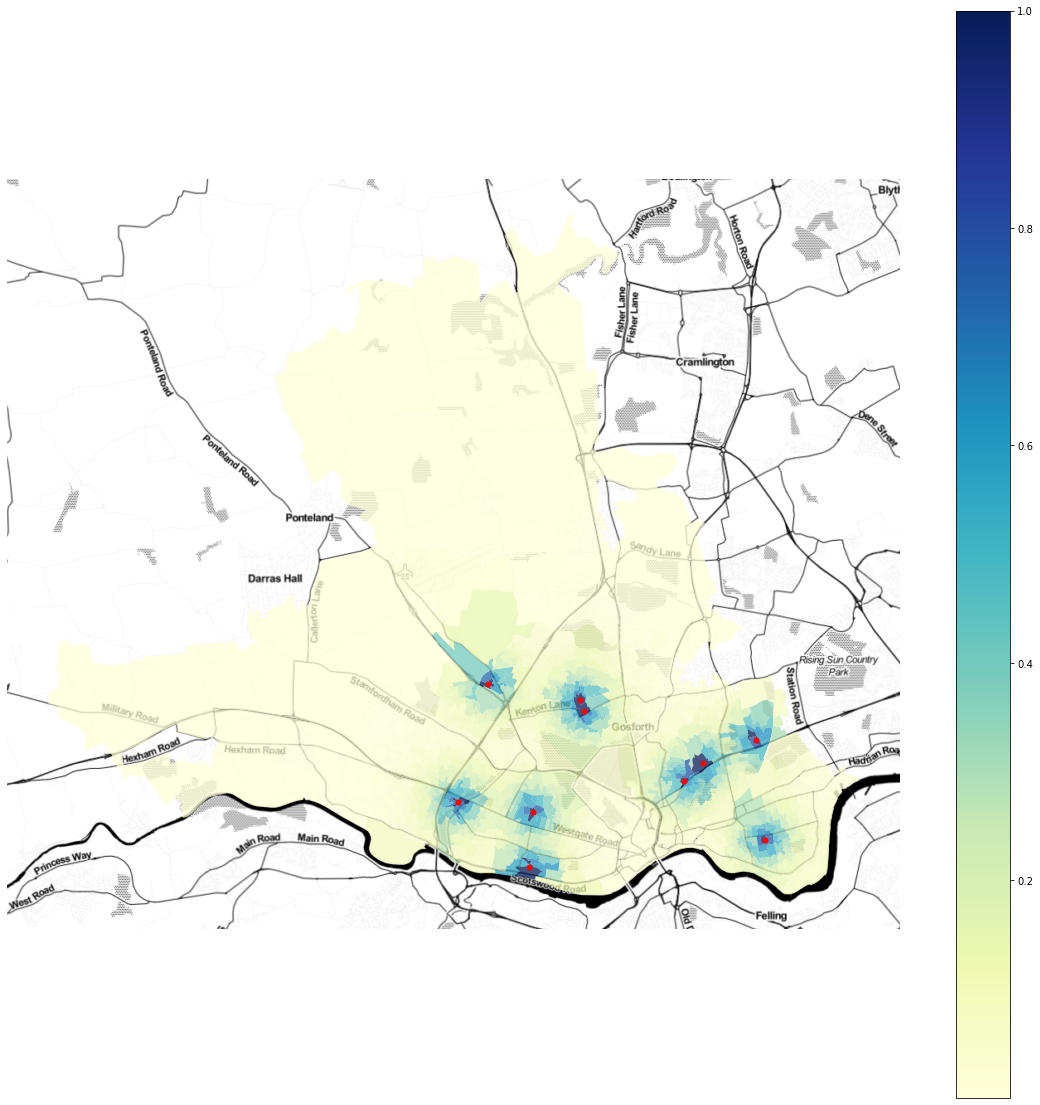

In [11]:
tyne_oa["satisfaction"] = max_mask_sat

ax = tyne_oa.plot(column="satisfaction",
                  figsize=(20,20),alpha=0.75,
                  cmap="YlGnBu", legend=True)

ctx.add_basemap(ax,
                url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

ax.set_axis_off()

x = tyne_oa.iloc[sensor_idx]["X"]
y = tyne_oa.iloc[sensor_idx]["Y"]
ax.scatter(x, y, s=24, color='r')


In [39]:
populations = tyne_oa["Population"].values

# Total population-weighted satisfaction of "solution"
(populations * max_mask_sat).sum()


952

In [25]:
display(max_mask_sat.shape)
display(populations.shape)
(max_mask_sat*populations.values)

(952,)

(952,)

array([5.83002238e+01, 7.59370390e+01, 4.18332039e+01, 6.54653919e+01,
       2.56773122e+02, 3.52000000e+02, 1.23474670e+02, 7.96488805e+01,
       6.54346366e+01, 1.30675218e+02, 3.40287943e+01, 6.71165908e+01,
       7.83723685e+01, 5.47617815e+01, 6.75871555e+01, 7.04107108e+01,
       1.94717926e+01, 1.61786693e+02, 2.86531177e+02, 3.21655881e+02,
       1.18861843e+02, 2.17478404e+02, 1.22461556e+02, 3.25000000e+02,
       1.35564479e+02, 2.03650517e+02, 7.74687284e+01, 7.17747548e+01,
       3.38946265e+01, 4.97088110e+01, 4.19876277e+01, 5.31128319e+01,
       4.42553664e+01, 4.68557486e+01, 4.70220308e+01, 3.53419254e+01,
       3.72965773e+01, 6.31591509e+01, 1.22261097e+02, 2.04334555e+02,
       1.26512687e+02, 1.14380145e+01, 1.64647599e+01, 3.04488469e+01,
       1.75247080e+01, 1.54433644e+01, 2.18733994e+01, 1.77176927e+01,
       4.32739441e+01, 2.51697975e+01, 2.33941841e+01, 2.05765034e+01,
       2.04116282e+01, 2.02623116e+01, 1.24858990e+01, 1.74599677e+01,
      

## PyGMO

In [163]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, centroids, populations,
                 n_sensors=10, theta=500):
        
        self.n_sensors = n_sensors
        self.centroids = centroids
        self.populations = populations
        
        # dimension of problem = number of candidate sensor locations
        self.dim = len(populations)
        
        self.distances = self._calc_distances(centroids)

        self.distance_to_satisfaction = np.vectorize(self._scalar_satisfaction)        
        self.satisfaction = self.distance_to_satisfaction(distances, theta=theta)
     
    def fitness(self, sensors):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # only keep satisfactions due to output areas where a sensor is present
        mask_sat = np.multiply(satisfaction, sensors[np.newaxis, :])

        # satisfaction at each output area = satisfaction due to nearest sensor
        max_mask_sat = np.max(mask_sat, axis=1)
        
        # Total population-weighted satisfaction of solution = our objective
        fitness_sensors = -(populations * max_mask_sat).sum()

        # constraint: have n_sensors sensors
        # equality constraints: must equal zero
        constraint_n_sensors = sensors.sum() - self.n_sensors
        
        return [fitness_sensors, constraint_n_sensors]
    

    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return ([0]*self.dim, [1]*self.dim)
    
    def get_nec(self):
        """PyGMO function.
        Defines number of equality constraints."""
        return 1
    
    def get_nix(self):
        """
        PyGMO function.
        Number of integer dimensions.
        """
        return self.dim
    
    def _gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    
    def _calc_distances(self, centroids):
        dist_sq = np.sum((centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                 axis = -1)

        distances = np.sqrt(dist_sq)
        
        return distances
    
    def _scalar_satisfaction(self, distance, theta):
        return np.exp(- distance/ theta)
    


In [164]:
# Build problem
prob = pg.problem(
        population_optimisation(centroids,
                                populations,
                                n_sensors,
                                theta)
      )

print(prob)

Problem name: <class '__main__.population_optimisation'>
	Global dimension:			952
	Integer dimension:			952
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [1, 1, 1, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none



In [165]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.gaco())


algo.set_verbosity(1)

# population of problems
pop = pg.population(prob=prob, size=100)


In [166]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 10100
g evals 0
champion f [-272257.68194303]
n_sensors 537.0
min sensors at location 0.0
max sensors at location 1.0


In [143]:
pop.champion_x

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 0.

10100